In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Search latest Datapoint
# session.query(Measurement.date).order_by(Measurement.date.desc()).all()
session.query(func.max(Measurement.date)).all()

[('2017-08-23',)]

Latest Datapoint is '2017-08-23'

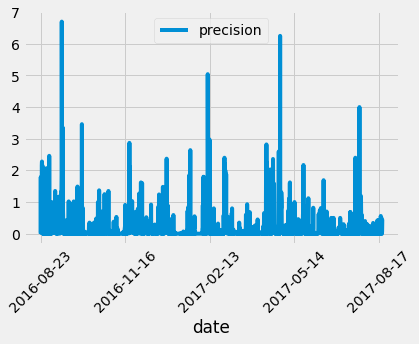

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
last_12m = dt.date(2017, 8, 23)-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
result_1 = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date>=last_12m).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame(result_1, columns =["date", "precision"]).\
    sort_values("date",ascending=True).dropna()
climate_df.set_index(climate_df["date"], inplace = True)

# Sort the dataframe by date
climate_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
climate_df.plot(rot = 45)
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate_df.describe()

,precision
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9,)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

As shown above, the station which has the most Datapoints is 'USC00519281'.

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

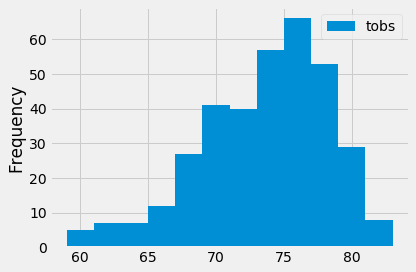

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result_2 = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= last_12m).all()
tobs_df = pd.DataFrame(result_2, columns = ["tobs"])
tobs_df.plot.hist(bins = 12)
plt.tight_layout()

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tobs_hawaii = calc_temps('2016-08-23', '2017-08-23')
tobs_hawaii

[(58.0, 74.59058295964125, 87.0)]

12.409417040358747


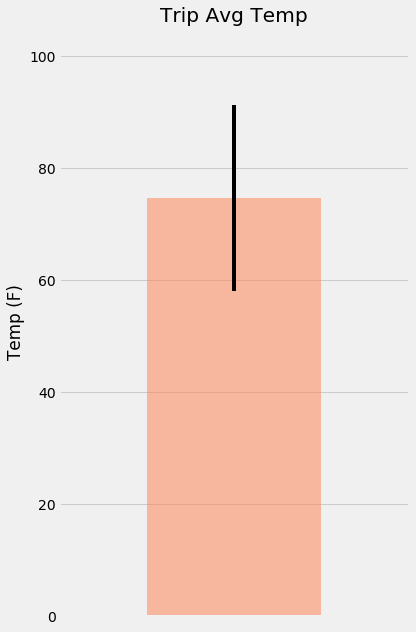

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_tobs_hawaii = tobs_hawaii[0][0]
avg_tobs_hawaii = tobs_hawaii[0][1]
max_tobs_hawaii = tobs_hawaii[0][2]

min_error = avg_tobs_hawaii - min_tobs_hawaii
max_error = max_tobs_hawaii - avg_tobs_hawaii

print(max_error)

error_bars = np.array([[min_error], [max_error]])

tobs_hawaii_df = pd.DataFrame(tobs_hawaii, columns = ["tmin","tavg","tmax"])
tobs_hawaii_df.plot.bar(y ='tavg', yerr = error_bars, title='Trip Avg Temp',\
                        color ='coral', alpha = 0.5, figsize = (6,9)).\
                        get_xaxis().set_visible(False)
plt.ylim(0, 105)
plt.ylabel('Temp (F)')
plt.tight_layout()
plt.gca().legend_.remove()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list
# the station, name, latitude, longitude, and elevation

ws_rainfall = session.query(Station.station, Station.name, Station.latitude,\
                            Station.longitude, Station.elevation, Measurement.prcp).\
                filter(Measurement.station == Station.station).\
                filter(Measurement.date >= '2016-08-23').\
                filter(Measurement.date <= '2017-08-23').\
                group_by(Measurement.station).\
                order_by(Measurement.prcp.desc()).all()

ws_rainfall

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.79),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.7),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.15),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.05),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.02),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
sta_date = '2021-08-07'
end_date = '2021-08-16'

end_date

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

start = dt.datetime.strptime(sta_date, '%Y-%m-%d')
end = dt.datetime.strptime(end_date, '%Y-%m-%d')

trip_dates = []
normals = []

while (start <= end):
    trip_dates.append(dt.datetime.strftime(start, '%Y-%m-%d'))
    datestr = dt.datetime.strftime(start, '%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    start = start + dt.timedelta(days = 1)

normals

[[71.0, 77.15686274509804, 83.0],
 [68.0, 76.5576923076923, 83.0],
 [69.0, 75.98039215686275, 81.0],
 [65.0, 76.42, 83.0],
 [67.0, 75.98113207547169, 82.0],
 [67.0, 76.52727272727273, 83.0],
 [71.0, 76.98245614035088, 84.0],
 [71.0, 76.77777777777777, 82.0],
 [69.0, 76.47169811320755, 83.0],
 [69.0, 76.08, 83.0]]

In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
vac_hawaii_df = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
vac_hawaii_df['Date'] = trip_dates
vac_hawaii_df = vac_hawaii_df.set_index('Date')
vac_hawaii_df

,tmin,tavg,tmax
Date,,,
2021-08-07,71.0,77.156863,83.0
2021-08-08,68.0,76.557692,83.0
2021-08-09,69.0,75.980392,81.0
2021-08-10,65.0,76.420000,83.0
2021-08-11,67.0,75.981132,82.0
2021-08-12,67.0,76.527273,83.0
2021-08-13,71.0,76.982456,84.0
2021-08-14,71.0,76.777778,82.0
2021-08-15,69.0,76.471698,83.0


(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 <a list of 7 Text xticklabel objects>)

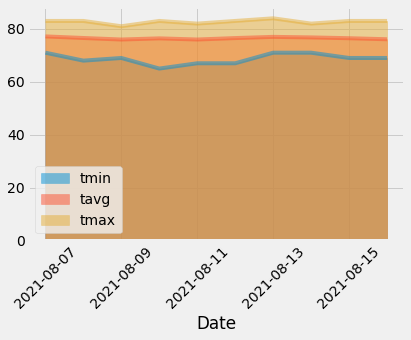

In [26]:
# Plot the daily normals as an area plot with `stacked=False`
vac_hawaii_df.plot.area(stacked=False)
plt.xticks(rotation=45)